In [1]:
import json
import os
import re
import textwrap

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score

/home/subarna/ut_395t_nlp_final_project/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define a function to pretty-print JSON with wrapped lines
def pretty_print_json(data, max_width=80):
    json_str = json.dumps(data, indent=4)
    wrapped_lines = []
    for line in json_str.splitlines():
        wrapped_lines.extend(textwrap.wrap(line, width=max_width))
    return "\n".join(wrapped_lines)

file_path = os.path.join("eval_baseline_emrqa", "eval_predictions.jsonl")
with open(file_path, "r") as file:
    predictions = [json.loads(line) for line in file]

# Filter failed examples where the predicted answer does not match the expected answer
failed_examples = [
    prediction for prediction in predictions
    if prediction['predicted_answer'] != prediction['answers']['text'][0] # for whatever reason this is a list
]

# Put Failed examples in a dataframe
failed = pd.DataFrame(failed_examples)
failed['answer'] = [v['text'][0] for v in failed["answers"].values]
# pd.set_option('display.max_colwidth', 20)
failed.columns
len(failed)

3248

### Rule Based Analysis based on Span and character matches

In [6]:
# -----------------------------
# 1. Basic helpers
# -----------------------------

STOPWORDS = {
    "the","a","an","and","or","but","if","then","so","for","of","on","in","to",
    "with","without","by","at","from","as","is","are","was","were","be","been",
    "being","that","this","these","those","it","its","into","about","than",
    "such","which","who","whom","whose","what","when","where","why","how"
}

def tokenize(text):
    return re.findall(r"\w+|\d+|\S", text.lower())

def content_tokens(text):
    toks = tokenize(text)
    return [t for t in toks if t.isalpha() and t not in STOPWORDS]

def jaccard_overlap(a, b):
    A = set(content_tokens(a))
    B = set(content_tokens(b))
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)

def has_number(text):
    return bool(re.search(r"\d", text))

def count_numbers(text):
    return len(re.findall(r"\d+(?:\.\d+)?", text))

MONTH_PAT = r"(jan|feb|mar|apr|may|jun|jul|aug|sep|sept|oct|nov|dec)"
DATE_PAT = rf"(\d{{1,2}}/\d{{1,2}}/\d{{2,4}}|\d{{4}}-\d{{1,2}}-\d{{1,2}}|{MONTH_PAT})"

def count_dates(text):
    return len(re.findall(DATE_PAT, text.lower()))

def shannon_entropy(tokens):
    if not tokens:
        return 0.0
    counts = Counter(tokens)
    total = sum(counts.values())
    probs = [c/total for c in counts.values()]
    return -sum(p*np.log(p + 1e-12) for p in probs)

def stopword_ratio(text):
    toks = tokenize(text)
    if not toks:
        return 0.0
    sw = sum(1 for t in toks if t in STOPWORDS)
    return sw / len(toks)

def classify_question_type(q):
    q_low = q.lower()
    if any(x in q_low for x in ["when", "date", "time", "year", "day", "month"]):
        return "time"
    if any(x in q_low for x in ["how many", "how much", "number", "count", "dose", "dosage", "mg", "mcg"]):
        return "number"
    return "other"

# -----------------------------
# 2. Global stats for thresholds (lengths)
# -----------------------------
# Compute gold answer lengths for failed examples
gold_lengths = failed['answer'].fillna("").apply(lambda x: len(tokenize(x)))

# 95th percentile of gold answer lengths (for anomaly thresholding)
length_p95 = np.percentile(gold_lengths, 95) if len(gold_lengths) > 0 else 100

# Median gold answer length (typical answer size)
length_med = np.median(gold_lengths) if len(gold_lengths) > 0 else 0

# Median absolute deviation (robust spread/variability)
mad = np.median(np.abs(gold_lengths - length_med)) if len(gold_lengths) > 0 else 0

# Tune this as needed
LENGTH_THRESHOLD = max(length_p95, length_med + 2 * mad)

# -----------------------------
# 3. Rule implementations (per-row)
# -----------------------------

def rule1_length_anomaly(answer_text):
    """Gold span length is abnormally large."""
    return len(tokenize(answer_text)) > LENGTH_THRESHOLD

def rule2_multi_clause(answer_text):
    """Gold span looks like multiple clauses/list items."""
    clauses = re.split(r',|\n|;|\band\b|\bor\b', answer_text, flags=re.IGNORECASE)
    informative = [c for c in clauses if len(content_tokens(c)) >= 3]
    return len(informative) > 1

def rule3_low_question_similarity(answer_text, question, sim_threshold=0.05):
    """Gold span has very low lexical overlap with question."""
    overlap = jaccard_overlap(answer_text, question)
    return overlap < sim_threshold

def rule4_pred_inside_gold_better_alignment(pred, gold, question, margin=0.1):
    """
    Predicted span is inside gold span AND aligns better with the question.
    Strong hint gold is a noisy chunk. This is a very important one.
    """
    gold_clean = gold or ""
    pred_clean = pred or ""
    if not pred_clean or pred_clean.strip() not in gold_clean:
        return False
    q_gold = jaccard_overlap(gold_clean, question)
    q_pred = jaccard_overlap(pred_clean, question)
    return q_pred > q_gold + margin

def rule5_question_type_mismatch(answer_text, question):
    """
    Question type vs answer structure mismatch:
    - time question but zero or multiple date-like expressions
    - number question but zero or many numeric expressions
    """
    qtype = classify_question_type(question)
    if qtype == "time":
        n_dates = count_dates(answer_text)
        return n_dates == 0 or n_dates > 1
    if qtype == "number":
        n_nums = count_numbers(answer_text)
        return n_nums == 0 or n_nums > 3  # >3 is "probably a list"
    return False

def rule6_multiple_occurrences_in_context(answer_text, context):
    """Gold span appears multiple times in the context: ambiguous / alignment suspect."""
    if not answer_text:
        return False
    return context.count(answer_text) > 1

def rule7_boundary_weirdness(answer_text):
    """Gold span starts/ends with separators or looks cut mid-clause."""
    txt = answer_text.strip()
    if not txt:
        return False
    if txt.startswith((",", ";", "and", "or")):
        return True
    if txt.endswith((",", ";", "and", "or")):
        return True
    # starts/ends with odd characters
    if txt[0] in "/-:" or txt[-1] in "/-:":
        return True
    return False

def rule8_pred_answers_question_better(pred, gold, question, margin=0.1):
    """Pred span has much better question alignment than gold (even if not substring)."""
    q_gold = jaccard_overlap(gold or "", question)
    q_pred = jaccard_overlap(pred or "", question)
    return q_pred > q_gold + margin

# -----------------------------
# 4. Apply rules to `failed` dataframe
# -----------------------------

def compute_dataset_error_flags(row):
    ctx = row.get("context", "") or ""
    q   = row.get("question", "") or ""
    gold = row.get("answer", "") or ""
    pred = row.get("predicted_answer", "") or ""

    r1 = rule1_length_anomaly(gold)
    r2 = rule2_multi_clause(gold)
    r3 = rule3_low_question_similarity(gold, q)
    r4 = rule4_pred_inside_gold_better_alignment(pred, gold, q)
    r5 = rule5_question_type_mismatch(gold, q)
    r6 = rule6_multiple_occurrences_in_context(gold, ctx)
    r7 = rule7_boundary_weirdness(gold)
    r8 = rule8_pred_answers_question_better(pred, gold, q)

    flags = {
        "rule1_length_anomaly": r1,
        "rule2_multi_clause": r2,
        "rule3_low_q_similarity": r3,
        "rule4_pred_inside_gold_better": r4,
        "rule5_qtype_mismatch": r5,
        "rule6_multi_occurrences": r6,
        "rule7_boundary_weirdness": r7,
        "rule8_pred_better_q_alignment": r8,
    }
    # simple score: how many rules think "dataset error"
    flags["dataset_error_score"] = sum(flags.values())
    # threshold: at least 2 rules triggered -> call it dataset error (tune this)
    flags["is_dataset_error"] = flags["dataset_error_score"] >= 2
    return pd.Series(flags)

# Apply to all failed examples
error_flags = failed.apply(compute_dataset_error_flags, axis=1)
failed_with_flags = pd.concat([failed, error_flags], axis=1)


In [7]:
# -----------------------------
# 5. Quick sanity checks / summaries
# -----------------------------

print("Total failed examples:", len(failed_with_flags))
print("Flagged as dataset errors:", failed_with_flags["is_dataset_error"].sum())

print("\nRule trigger rates:")
print(failed_with_flags[
    [c for c in failed_with_flags.columns if c.startswith("rule")]
].sum().sort_values(ascending=False))

Total failed examples: 3248
Flagged as dataset errors: 2173

Rule trigger rates:
rule2_multi_clause               2416
rule7_boundary_weirdness         2322
rule3_low_q_similarity            344
rule5_qtype_mismatch              332
rule1_length_anomaly              146
rule8_pred_better_q_alignment     110
rule6_multi_occurrences            96
rule4_pred_inside_gold_better      47
dtype: int64


In [8]:
# Identify rule columns
rule_cols = [c for c in failed_with_flags.columns if c.startswith("rule")]

# Compute summary
summary = pd.DataFrame({
    "count": failed_with_flags[rule_cols].sum(),
    "percent": failed_with_flags[rule_cols].mean() * 100
}).sort_values("count", ascending=False)
summary

,count,percent
rule2_multi_clause,2416,74.384236
rule7_boundary_weirdness,2322,71.490148
rule3_low_q_similarity,344,10.591133
rule5_qtype_mismatch,332,10.221675
rule1_length_anomaly,146,4.495074
rule8_pred_better_q_alignment,110,3.386700
rule6_multi_occurrences,96,2.955665
rule4_pred_inside_gold_better,47,1.447044


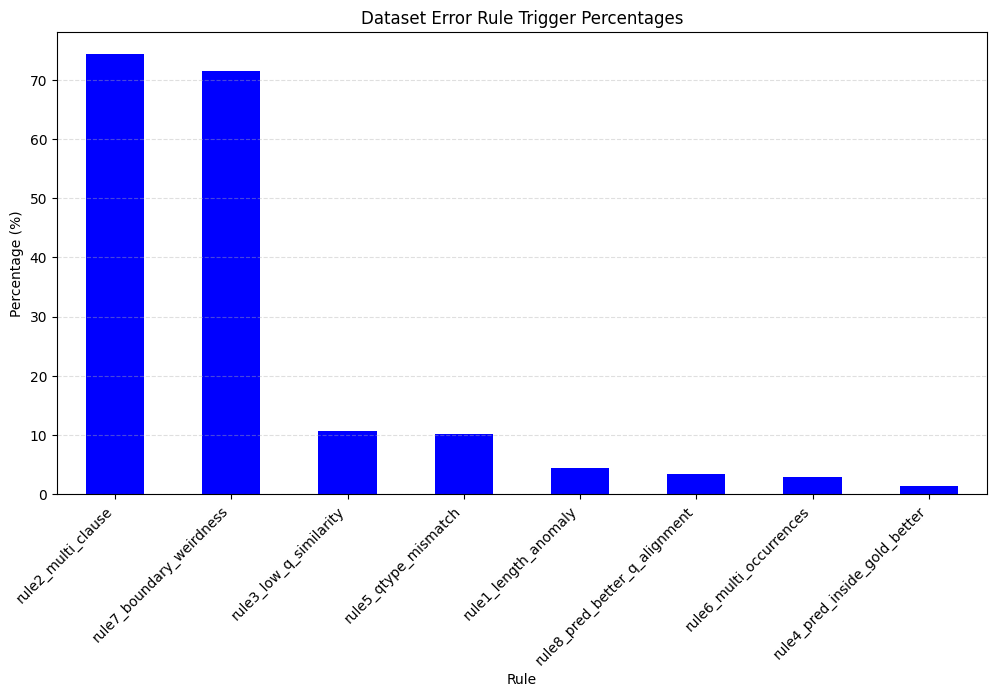

In [9]:
plt.figure(figsize=(12, 6))
summary["percent"].plot(kind="bar", color="blue")
plt.title("Dataset Error Rule Trigger Percentages")
plt.ylabel("Percentage (%)")
plt.xlabel("Rule")
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

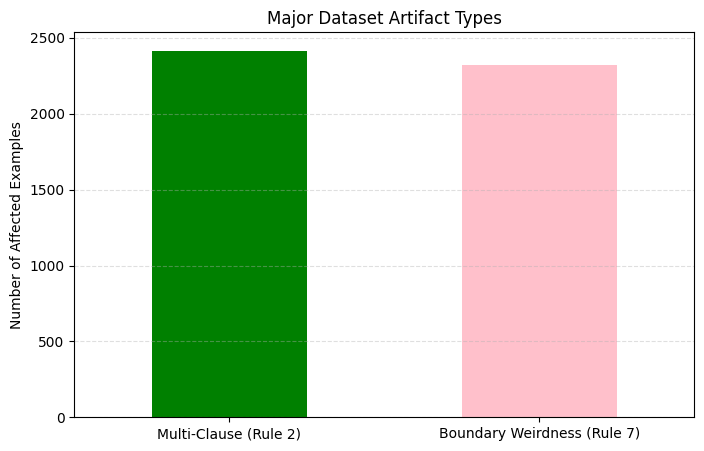

In [10]:
r2 = failed_with_flags[failed_with_flags["rule2_multi_clause"]]
r7 = failed_with_flags[failed_with_flags["rule7_boundary_weirdness"]]
counts = pd.Series({
    "Multi-Clause (Rule 2)": r2.shape[0],
    "Boundary Weirdness (Rule 7)": r7.shape[0]
})

plt.figure(figsize=(8,5))
counts.plot(kind="bar", color=["green", "pink"])
plt.title("Major Dataset Artifact Types")
plt.ylabel("Number of Affected Examples")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.4, linestyle="--")
plt.show()

In [ ]:
len(failed[failed['predicted_answer'] == ',']), len(failed[failed['predicted_answer'] == '.'])

###  Baseline EMRQA prediction error analysis
- High-level error patterns for `eval_baseline_emrqa/eval_predictions.jsonl`
- Label wrong predictions as `truncated_span`, `overlong_span`, `partial_overlap`, or `no_overlap` and show counts/examples.

In [13]:
# Helpers
token_re = re.compile(r"\w+")
relation = ["truncated_span", "overrun_span", "partial_overlap", "no_overlap"]

def norm(text):
    return " ".join(text.lower().split())

def tokens(text: str):
    return token_re.findall(text.lower())

def span_relation(prediction: str, actual: str):
    p = norm(prediction)
    a = norm(actual)
    if p and p in a:
        return relation[0]
    if a and a in p:
        return relation[1]
    if set(tokens(p)) & set(tokens(a)):
        return relation[2]
    return relation[3]

# Add a new column to the failed dataframe for the span relation
failed['relation'] = failed.apply(
    lambda row: span_relation(
        row.get("predicted_answer", ""),
        row.get("answer", "")
    ),
    axis=1
)

# Display counts from the failed dataframe
print(f"Total wrong predictions: {len(failed)}")
print("Wrong predictions by type:")
print(failed["relation"].value_counts())

# Use the following filter to deep dive
# Sample examples from each relation type
samples = []
for rel in relation:
    rel_samples = failed[failed["relation"] == rel][["id", "question", "predicted_answer", "answer", "relation"]].head(3)
    samples.append(rel_samples)

pd.concat(samples, ignore_index=True)

Total wrong predictions: 3248
Wrong predictions by type:
relation
truncated_span     2714
overrun_span        272
partial_overlap     193
no_overlap           69
Name: count, dtype: int64


,id,question,predicted_answer,answer,relation
0,7,Was the patient ever given roxicet elixir ( ox...,RO,ROXICET ELIXIR (OXYCODONE+APAP LIQUID) 5-10 MI...,truncated_span
1,9,Has this patient ever been prescribed gemfibrozil,",","Epogen 2,000 subcu q. week, Lasix 60 mg p.o. q...",truncated_span
2,15,Has this patient ever been treated with prempro,Prempro 0.625/0.25 mg p.o. q. day.,"Cellcept 1,000 mg p.o. b.i.d., and Prempro 0.6...",truncated_span
3,45,Why is the patient on coumadin,"to maintain INR between 2 and 3, aspirin, Dilt...","maintain INR between 2 and 3, aspirin, Diltia...",overrun_span
4,103,What is the current dose of maalox,Maalox 1-2 tabs p.o. q.6h. p.r.n. pain. and,Maalox 1-2 tabs p.o. q.6h. p.r.n. pain.,overrun_span
5,241,Has this patient ever been prescribed maalox,Maalox 1-2 tabs p.o. q.6h. p.r.n. pain. and,Maalox 1-2 tabs p.o. q.6h. p.r.n. pain.,overrun_span
6,311,Has the patient had cephradine in the past,"Atenolol 100 mg p.o. q. daily,","Cephradine 100 mg p.o. q.i.d. times five days,",partial_overlap
7,407,How often does the patient take lisinopril,"Dilaudid 2-4 mg every three hours p.r.n. pain,...","lisinopril 2.5 mg daily, Niferex 150 mg b.i.d....",partial_overlap
8,566,What is the dosage of dopamine,there was a postoperative increase in creatini...,increase in creatinine requiring dopamine 2 mc...,partial_overlap
9,497,What is the patient's current dose does the pa...,"30 MILLILITERS PO DAILY PRN Constipation,",Sliding Scale (subcutaneously) SC AC+HS Medium...,no_overlap


### Deep Dive into Baseline EMRQA Prediction Errors

Cluster error types in failed examples for further analysis. This uses sentence transformers to embed the question, context, and predicted/true answers, then clusters them using KMeans. This seems to work better. However, the clusters are still not very meaningful. Further work is needed here.

In [14]:
failed['gold_norm'] = failed['answer'].apply(norm)
failed['pred_norm'] = failed['predicted_answer'].apply(norm)
failed["clust_text"] = failed.apply(
    lambda r: f"Q: {r['question']} GOLD: {r['gold_norm']} PRED: {r['pred_norm']}",
    axis=1
)

model = SentenceTransformer("all-mpnet-base-v2")

embed_texts = failed["clust_text"].tolist()
embeddings = model.encode(
    embed_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

embeddings.shape
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(embeddings)

failed["pca_x"] = pca_2d[:, 0]
failed["pca_y"] = pca_2d[:, 1]

Batches: 100%|██████████| 51/51 [00:02<00:00, 17.91it/s]


k= 2  silhouette=0.0633
k= 3  silhouette=0.0604
k= 4  silhouette=0.0472
k= 5  silhouette=0.0576
k= 6  silhouette=0.0578
k= 7  silhouette=0.0603
k= 8  silhouette=0.0605
k= 9  silhouette=0.0589
k=10  silhouette=0.0440
k=11  silhouette=0.0629
k=12  silhouette=0.0519
k=13  silhouette=0.0473
k=14  silhouette=0.0541
k=15  silhouette=0.0521


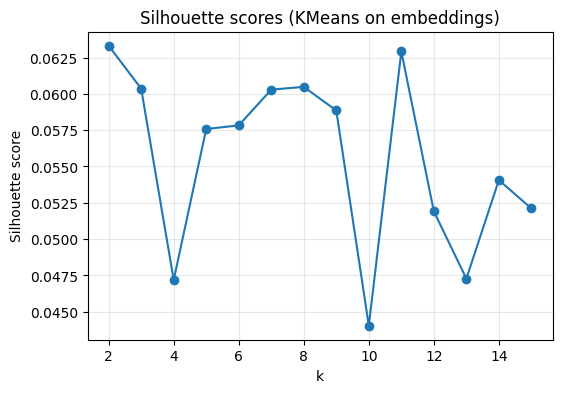

In [15]:
ks = list(range(2, 16))
sil_scores = []

for k in ks:
    km = KMeans(
        n_clusters=k,
        random_state=0,
        n_init=10,
        max_iter=300
    )
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    sil_scores.append(score)
    print(f"k={k:2d}  silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores (KMeans on embeddings)")
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
best_k = 2

kmeans = KMeans(
    n_clusters=best_k,
    random_state=0,
    n_init=10,
    max_iter=300
)
k_labels = kmeans.fit_predict(embeddings)

failed["cluster_kmeans"] = k_labels
failed["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0     931
1    2317
Name: count, dtype: int64

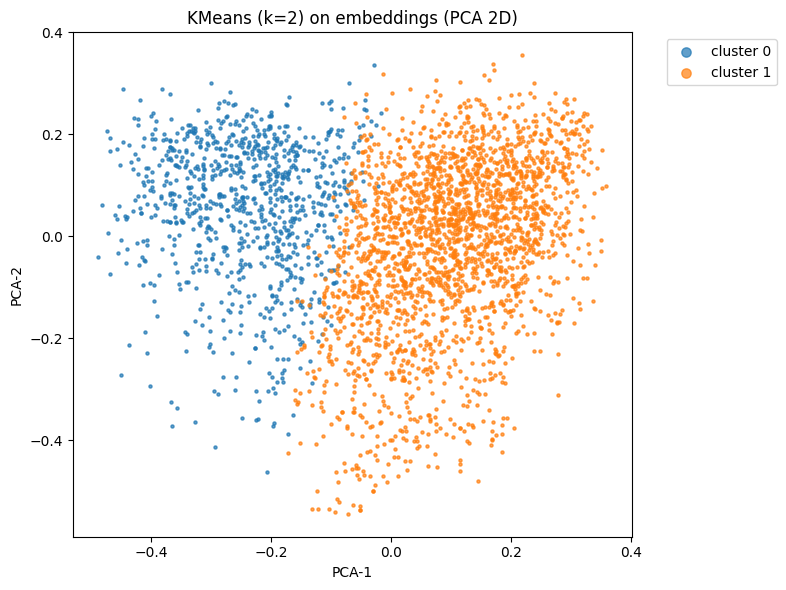

In [19]:
plt.figure(figsize=(8, 6))

for cid in sorted(failed["cluster_kmeans"].unique()):
    mask = failed["cluster_kmeans"] == cid
    plt.scatter(
        failed.loc[mask, "pca_x"],
        failed.loc[mask, "pca_y"],
        s=5,
        alpha=0.7,
        label=f"cluster {cid}"
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(f"KMeans (k={best_k}) on embeddings (PCA 2D)")
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [20]:
cluster_k_info = {}

for cid in sorted(failed["cluster_kmeans"].unique()):
    sub = failed[failed["cluster_kmeans"] == cid]
    n = len(sub)
    rel_dist = sub["relation"].value_counts().to_dict()
    
    top_terms = []
    if n >= 5:
        cv = CountVectorizer(
            max_features=2000,
            ngram_range=(1,2),
            stop_words="english"
        )
        Xq = cv.fit_transform(sub["question"].astype(str).tolist())
        sums = np.asarray(Xq.sum(axis=0)).ravel()
        terms = np.array(cv.get_feature_names_out())
        top_idx = sums.argsort()[::-1][:15]
        top_terms = list(terms[top_idx])
    
    cluster_k_info[cid] = {
        "n": n,
        "relation_dist": rel_dist,
        "top_terms": top_terms,
    }

for cid, info in cluster_k_info.items():
    print("="*80)
    print(f"Cluster {cid}  |  n = {info['n']}")
    print("Error-type distribution:", info["relation_dist"])
    print("Top question terms:", ", ".join(info["top_terms"]))
    print()

Cluster 0  |  n = 931
Error-type distribution: {'truncated_span': 716, 'partial_overlap': 115, 'overrun_span': 77, 'no_overlap': 23}
Top question terms: patient, current, dose, current dose, does, does patient, dosage, prescribed, dose patient, patient day, dose does, patient current, day, dosage prescribed, previous

Cluster 1  |  n = 2317
Error-type distribution: {'truncated_span': 1998, 'overrun_span': 195, 'partial_overlap': 78, 'no_overlap': 46}
Top question terms: patient, prescribed, patient prescribed, tried, patient tried, past, pain, medications, record, prior, nitroglycerin, used, pt, taken, 150



### Manual Review of Sampled Errors

- No. of questions in the train dataset that start with "has" is 62872/130,956
- No. of questions in the validation dataset that start with "has" is 15913/32739
- No. of questions in the failed examples that start with "has" is 1423/3248

This examines the whole dataset for train and eval to see how many questions start with "has", 'why' etc.

In [ ]:
train = load_dataset("Eladio/emrqa-msquad", split="train")

# Filter questions that start with "why"
why_questions = train.filter(lambda example: example["question"].lower().startswith("why"))

why_questions_df = pd.DataFrame(why_questions)
len(why_questions_df)

In [ ]:
eval = load_dataset("Eladio/emrqa-msquad", split="validation")

# Filter questions that start with "has"
has_questions = eval.filter(lambda example: example["question"].lower().startswith("has"))

# Display the filtered examples
has_questions_df = pd.DataFrame(has_questions)
has_questions_df['question']

Insulin

In [ ]:
insulin_questions = failed[failed['question'].str.contains('insulin', case=False, na=False)]
len(insulin_questions)

Chest pain

In [ ]:
chest_pain_questions = failed[failed['question'].str.contains('chest pain', case=False, na=False)]
len(chest_pain_questions)

Medication

In [ ]:
medication_questions = failed[failed['question'].str.contains('medication', case=False, na=False)]
len(chest_pain_questions)

Gemfibrozil

In [11]:
gemfibrozil_examples = failed[failed['question'].str.lower().str.contains('gemfibrozil')]
gemfibrozil_examples.head(5)

,context,question,answers,id,predicted_answer,answer
1,Ms. Leezer is a 50 year-old woman with a histo...,Has this patient ever been prescribed gemfibrozil,"{'answer_end': [1806], 'answer_start': [1722],...",9,",","Epogen 2,000 subcu q. week, Lasix 60 mg p.o. q..."
592,Ms. Leezer is a 50 year-old woman with a histo...,Has patient ever been prescribed gemfibrozil,"{'answer_end': [1806], 'answer_start': [1722],...",5865,",","Epogen 2,000 subcu q. week, Lasix 60 mg p.o. q..."
1188,Ms. Leezer is a 50 year-old woman with a histo...,gemfibrozil,"{'answer_end': [1806], 'answer_start': [1722],...",11836,"Gemfibrozil 300 mg p.o. b.i.d.,","Epogen 2,000 subcu q. week, Lasix 60 mg p.o. q..."
2189,Ms. Leezer is a 50 year-old woman with a histo...,Has the patient ever tried gemfibrozil,"{'answer_end': [1806], 'answer_start': [1722],...",21939,",","Epogen 2,000 subcu q. week, Lasix 60 mg p.o. q..."
2257,Ms. Leezer is a 50 year-old woman with a histo...,Has this patient ever been on gemfibrozil,"{'answer_end': [1806], 'answer_start': [1722],...",22602,",","Epogen 2,000 subcu q. week, Lasix 60 mg p.o. q..."


### Ignore for the time being
Tfidf + k-means did not yield meaningful clusters here.

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=5
)

X = vectorizer.fit_transform(failed["clust_text"])
# X.shape
k = 10
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=100)
cluster_labels = kmeans.fit_predict(X)

failed["cluster"] = cluster_labels
cluster_sizes = failed["cluster"].value_counts().sort_index()
# cluster_sizes

# per cluster analysis
cluster_summaries = {}

for c in sorted(failed["cluster"].unique()):
    sub = failed[failed["cluster"] == c]

    qs = sub["question"].astype(str).tolist()
    if len(qs) < 5:
        continue

    cv = CountVectorizer(
        max_features=2000,
        ngram_range=(1,3),
        stop_words="english"
    )
    Xq = cv.fit_transform(qs)

    sums = np.asarray(Xq.sum(axis=0)).ravel()
    terms = np.array(cv.get_feature_names_out())
    top_idx = sums.argsort()[::-1][:15]

    cluster_summaries[c] = {
        "n": len(sub),
        "top_terms": list(terms[top_idx]),
        "error_dist": sub["relation"].value_counts().to_dict()
    }

# cluster_summaries

for c in sorted(cluster_summaries.keys()):
    info = cluster_summaries[c]
    print("="*70)
    print(f"Cluster {c}  |  n = {info['n']}")
    print("Top terms:", ", ".join(info["top_terms"]))
    print("Error types:", info["error_dist"])
    print()

    ks = list(range(2, 25))
sse = []

# find the right k
for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=200)
    km.fit(X)
    sse.append(km.inertia_)

plt.plot(ks, sse, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.show()